In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#load dataset
test_data=pd.read_csv('df_test.csv')
train_data=pd.read_csv('df_train.csv')

In [ ]:
print(train_data.head())

         date  power_consumption  year  semester  quarter day_in_week  \
0  12/16/2006           1209.176  2006         2        4         Sat   
1  12/17/2006           3390.460  2006         2        4         Sun   
2  12/18/2006           2203.826  2006         2        4         Mon   
3  12/19/2006           1666.194  2006         2        4         Tue   
4  12/20/2006           2225.748  2006         2        4         Wed   

   week_in_year  day_in_year  month  
0            50          350     12  
1            51          351     12  
2            51          352     12  
3            51          353     12  
4            51          354     12  


In [ ]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1202 non-null   object 
 1   power_consumption  1202 non-null   float64
 2   year               1202 non-null   int64  
 3   semester           1202 non-null   int64  
 4   quarter            1202 non-null   int64  
 5   day_in_week        1202 non-null   object 
 6   week_in_year       1202 non-null   int64  
 7   day_in_year        1202 non-null   int64  
 8   month              1202 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 84.6+ KB
None


In [ ]:
# as date col 12/16/2006 is string we need to convert it into datetime
# df['date'].dt.dayofweek is used to get day of week ---> [0: monday , 1: tuesday ...]
# df['date'].dt.day gets the day of month
# df['date'].dt.momth gets  month number
# .dt is used when its in date and time

# so to convert the date and time
# pandas.to_datetime(column_to_convert,formate=" ")  ---> formate of date
# Convert date to datetime
train_data['date'] = pd.to_datetime(train_data['date'], format='%m/%d/%Y')
test_data['date'] = pd.to_datetime(test_data['date'], format='%m/%d/%Y')

#If your date was "16-Dec-2006", the format would be format='%d-%b-%Y'.
#If your date was "2006, December 16", the format would be format='%Y, %B %d'.



# Feature engineering

In [ ]:
for df in [train_data,test_data]:
  #we know that power consuption is very differnt compare to weekdays
  # we can include this for our model
  df['day_of_week']=df['date'].dt.dayofweek

  # we can provide as simple signal to model that day is a weekend
  # which is very strong predictor for our model
  df['is_weekend']=df['date'].isin([5,6]).astype(int) # as 5:sat and 6:sun [5,6] .isin ---> if they are or not for rows
  # if they are means true else fasle ---> to covert them in 0 and 1 we use .astype(int)
  # 1--> sat and 0--> sun


  # our consuption pattern might be realted to start,middle,end of month
  df['day_of_month']=df['date'].dt.day # extract date number --> 1 ,31




  # we can also group the months in 4 categories
  # Season 1: December, January, February (Winter)
  # Season 2: March, April, May (Spring)
  # Season 3: June, July, August (Summer)
  # Season 4: September, October, November (Autumn)

  # as seasons is important as during summer its hot and AC run more power
  # as in winter heater consume more power

  df['season']=df['month']%12 // 3 + 1
  # what is it doing ---> reminder div 3 ----+1---> [0 1 2 3]



# features and target

In [ ]:
# as we have extrated usefull features from date we will drop it
X_train=train_data.drop(columns=['power_consumption','date'])
y_train=train_data['power_consumption'] # train on this

X_test=test_data.drop(columns=['power_consumption','date'])
y_test=test_data['power_consumption'] # test on this

preproccsing pipline

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# in our dataset i have two features
# numeric features ---> year or day_of_month
# categorical features --> day_of_week, 1 2 3 4 for seasons

# we process these two type diffentelty and extract the ColumnTransformer is design for


#preprocessor = ColumnTransformer(...)  ---> here it creates object which is used for list of instruction
preprocessor = ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numeric_features),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_features)
    ])


#StandardScaler()
'''
StandardScaler(): This is the transformation object. It scales all the numerical features
so they have a mean of 0 and a standard deviation of 1.

Why do this? Features with very different scales (e.g., year is ~2008, while is_weekend is 0 or 1)
can cause problems for some models (like Linear Regression). Scaling puts all features on a level playing field,
which often improves model performance and stability.

numeric_features: This tells the ColumnTransformer to apply StandardScaler only to the columns listed in numeric_features.

'''


#OneHotEncoder()
'''
OneHotEncoder(): This is the transformer.
It converts categorical data into a numerical format. It takes each category in a column and creates a new binary (0/1) column for it.
For example, for the day_in_week column, it might create new columns like day_in_week_Mon, day_in_week_Tue, etc.
If a row's original day was 'Mon', the day_in_week_Mon column will be 1 and all other new day columns will be 0.

Models can't understand text like 'Mon'



handle_unknown='ignore'-->if the model encounters a category in the test data that it never saw in the training data,
this tells the encoder to simply ignore it (by making all its new columns 0) instead of throwing an error.

categorical_features: This tells the ColumnTransformer to apply OneHotEncoder only to the columns listed in categorical_features.


'''

"\nOneHotEncoder(): This is the transformer.\nIt converts categorical data into a numerical format. It takes each category in a column and creates a new binary (0/1) column for it.\nFor example, for the day_in_week column, it might create new columns like day_in_week_Mon, day_in_week_Tue, etc.\nIf a row's original day was 'Mon', the day_in_week_Mon column will be 1 and all other new day columns will be 0.\n\nModels can't understand text like 'Mon'\n\n\n\nhandle_unknown='ignore'-->if the model encounters a category in the test data that it never saw in the training data,\nthis tells the encoder to simply ignore it (by making all its new columns 0) instead of throwing an error.\n\ncategorical_features: This tells the ColumnTransformer to apply OneHotEncoder only to the columns listed in categorical_features.\n\n\n"

In [ ]:
#initlize models
models={
    'LinearRegression':LinearRegression(),
    'RandomForest':RandomForestRegressor(n_estimators=500,max_depth=8,random_state=42),
    'XGBoost':XGBRegressor(n_estimators=500,max_depth=4,learning_rate=0.1,random_state=42)
}

# train models and evalute

In [ ]:
rmse_results={}
predictions={}

'''
rmse_results: This will be used to store the final performance score (the RMSE) for each model.
For example, {'Linear Regression': 750.25, 'Random Forest': 410.50, ...}.

predictions: This will store the actual list of predicted power consumption values from each model.
This is needed so you can plot the best model's predictions later.

'''

for name,model in models.items():
  #create pipline
  #two-step process:
  pipeline=Pipeline(
      steps=[
          ('preprocessor',preprocessor),
          ('model',model)
      ]
  )

  #train model
  pipeline.fit(X_train,y_train)

  #make prediction
  y_pred=pipeline.predict(X_test)
  predictions[name]=y_pred

  #calculate rmse
  rmse=np.sqrt(mean_squared_error(y_test,y_pred))
  rmse_results[name]=rmse
  print(f'{name} RMSE: {rmse:.2f}kW')



LinearRegression RMSE: 399.16kW
RandomForest RMSE: 403.83kW
XGBoost RMSE: 450.64kW


In [ ]:
# Get best model name
best_model_name = min(rmse_results, key=rmse_results.get)
best_predictions = predictions[best_model_name]

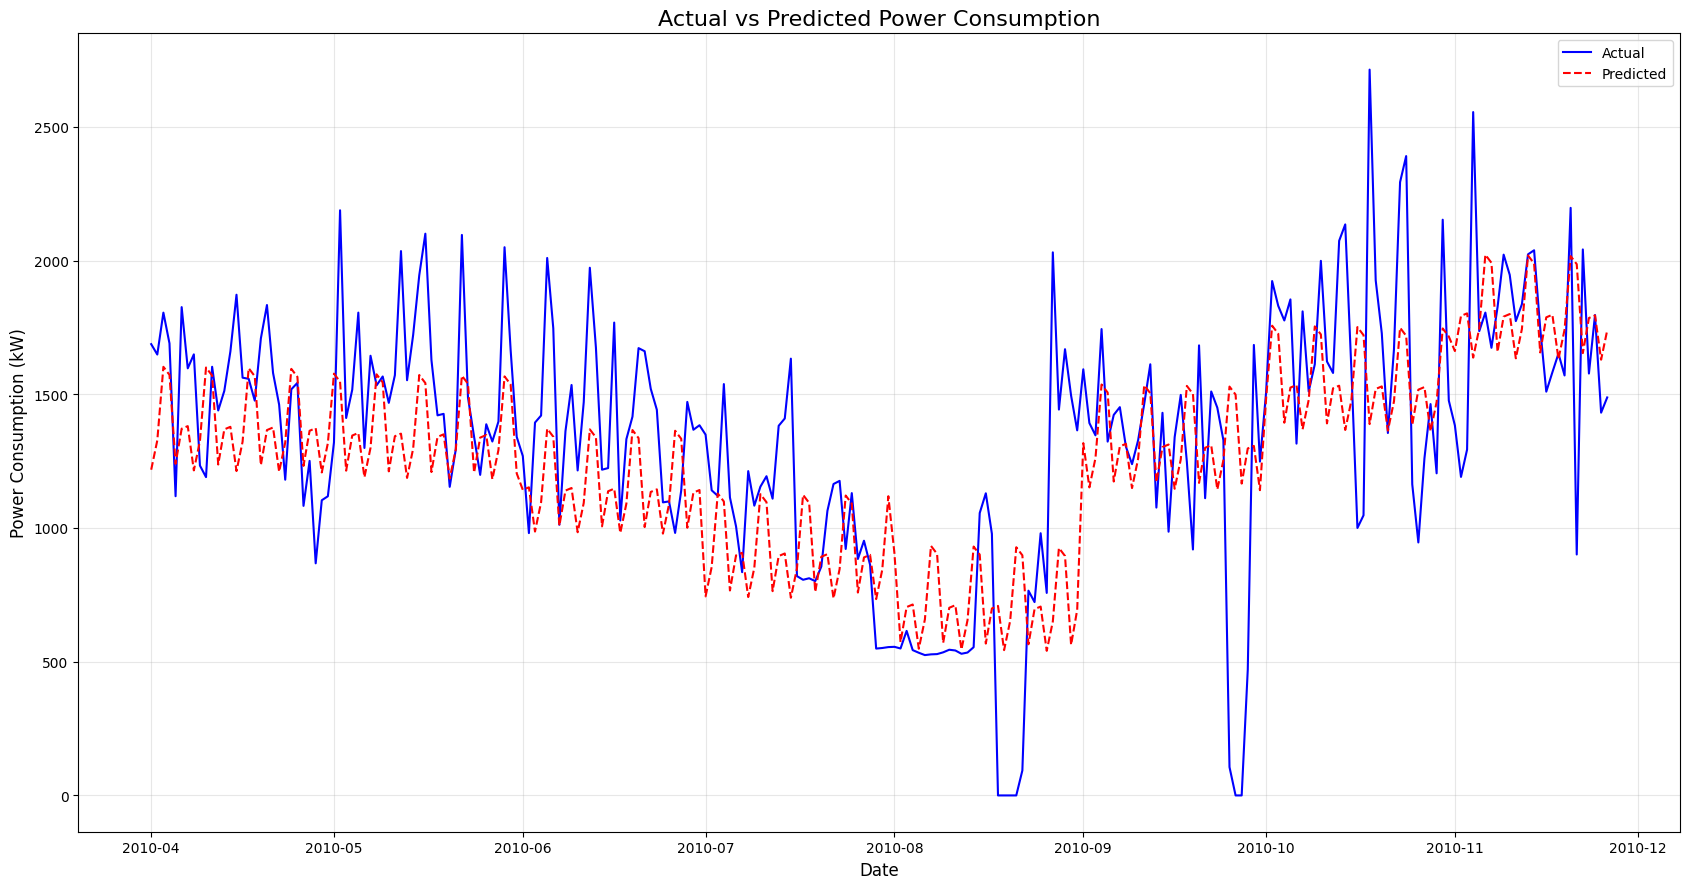


Final Results:
Selected RMSE: 399.16 kW
Trend Similarity: Yes


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(17, 9))
plt.plot(test_data['date'], y_test, label='Actual', color='blue', linewidth=1.5)
plt.plot(test_data['date'], best_predictions, label='Predicted',
         color='red', linestyle='--', linewidth=1.5)
plt.title('Actual vs Predicted Power Consumption', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kW)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('power_consumption_prediction.png', dpi=300)
plt.show()

# Assess trend similarity
trend_similarity = "Yes"

# Output results
print("\nFinal Results:")
print(f"Selected RMSE: {selected_rmse:.2f} kW")
print(f"Trend Similarity: {trend_similarity}")